# Prepare Environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy

from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.optim import lr_scheduler

In [2]:
# CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data/Footwear'

In [5]:
# data_dir = r'C:\Users\Mark.mphw\OneDrive - Mahidol University\iFile\Learning Session\SpecialTopicsInComputerScience\Lecture 10\Lab\Data\PlayStation'

In [6]:
# Transformations
# Train set: Data augmentation and normalization
# Validation set: Just normalization (no randomness)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Dataset
image_datasets = {}
for k in data_transforms.keys():
    image_datasets[k] = datasets.ImageFolder(
        root=os.path.join(data_dir, k),
        transform=data_transforms[k])

# DataLoader
batch_size = 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)
              for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


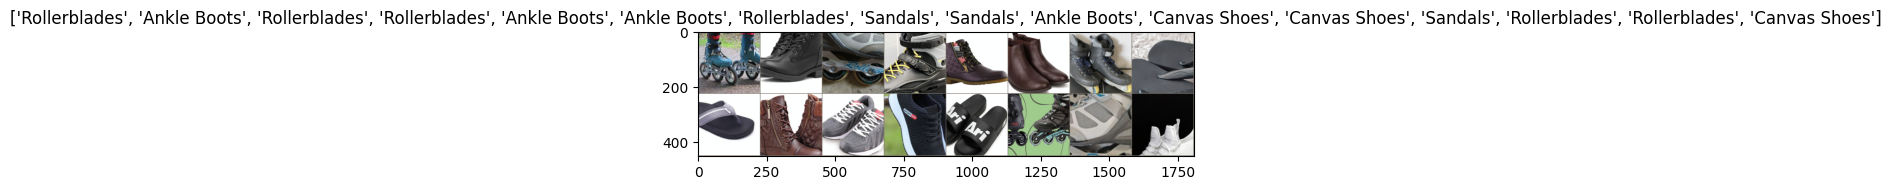

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # c, h, w --> h, w, c
    inp = inp.numpy().transpose((1, 2, 0))

    # De-normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot
imshow(out, title=[class_names[x] for x in classes])

# Transfer Learning

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Test mode
    model.eval()

    # Predict on test set
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Prediction
            pred = model(X)
            y_pred = pred.argmax(1)
            # Compute loss
            loss += loss_fn(pred, y).item()
            # Correct predictions
            correct += (y_pred == y).type(torch.float).sum().item()

    # Average loss
    loss /= num_batches

    # Accuracy
    accuracy = correct / size

    return loss, accuracy

## Pre-trained Model as Fixed Feature Extractor

In [11]:
# Pre-trained weights
model = torchvision.models.resnet18(pretrained=True)
# Freeze pre-trained weights --> no update during training
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.2MB/s]


In [12]:
# Let see the layers in the model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Get the last layer of the resnet18
num_ftrs = model.fc.in_features

# Replace the last layer with the classification layer
# Note: Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(num_ftrs, len(class_names))

# Move to desired device
model = model.to(device)

In [14]:
# Check number of trainable parameters
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
# Loss
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
# Train the model
model = train_model(
    model, criterion,
    optimizer_conv, exp_lr_scheduler,
    num_epochs=10)

Epoch 0/9
----------
train Loss: 1.5171 Acc: 0.2375
valid Loss: 1.3231 Acc: 0.3125

Epoch 1/9
----------
train Loss: 1.3048 Acc: 0.3125
valid Loss: 1.2591 Acc: 0.3875

Epoch 2/9
----------
train Loss: 1.0924 Acc: 0.6250
valid Loss: 1.1827 Acc: 0.3875

Epoch 3/9
----------
train Loss: 0.9724 Acc: 0.6750
valid Loss: 1.0937 Acc: 0.6375

Epoch 4/9
----------
train Loss: 0.8186 Acc: 0.8125
valid Loss: 1.0187 Acc: 0.6500

Epoch 5/9
----------
train Loss: 0.7903 Acc: 0.8000
valid Loss: 0.9717 Acc: 0.6625

Epoch 6/9
----------
train Loss: 0.7088 Acc: 0.8500
valid Loss: 0.9335 Acc: 0.6875

Epoch 7/9
----------
train Loss: 0.6515 Acc: 0.8000
valid Loss: 0.9312 Acc: 0.6875

Epoch 8/9
----------
train Loss: 0.5848 Acc: 0.9375
valid Loss: 0.9304 Acc: 0.6875

Epoch 9/9
----------
train Loss: 0.6141 Acc: 0.8375
valid Loss: 0.9253 Acc: 0.7000

Training complete in 3m 16s
Best valid Acc: 0.700000


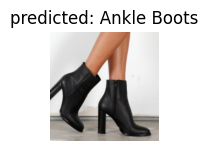

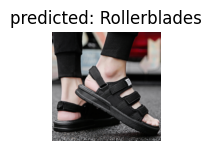

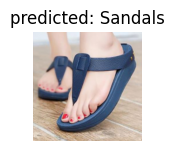

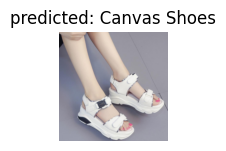

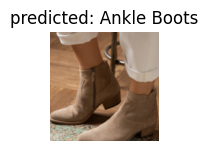

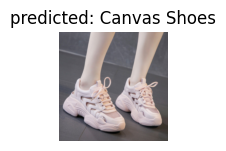

In [17]:
visualize_model(model)

In [18]:
test_loss, test_acc = test(dataloaders['test'], model, criterion)
print(f"Test: loss={test_loss:>8f}, acc={(100*test_acc):>0.1f}%")

Test: loss=0.707036, acc=80.0%


## Model Fine-tuning

In [19]:
layers = list(model.children())
for li, l in enumerate(layers):
    print(f"{li}: {l}")

0: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2: ReLU(inplace=True)
3: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [20]:
# Determine how many layers to freeze
fine_tune_at = 7
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True

In [21]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [22]:
# Loss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# Note: we typically use a lower learning rate for model fine-tuning
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model = train_model(
    model, criterion,
    optimizer_ft, exp_lr_scheduler,
    num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5027 Acc: 0.9000
valid Loss: 0.8811 Acc: 0.6500

Epoch 1/19
----------
train Loss: 0.1853 Acc: 0.9875
valid Loss: 0.8248 Acc: 0.6625

Epoch 2/19
----------
train Loss: 0.1898 Acc: 0.9625
valid Loss: 0.7376 Acc: 0.6750

Epoch 3/19
----------
train Loss: 0.1302 Acc: 0.9625
valid Loss: 0.7044 Acc: 0.6625

Epoch 4/19
----------
train Loss: 0.0751 Acc: 0.9750
valid Loss: 0.7527 Acc: 0.6625

Epoch 5/19
----------
train Loss: 0.0743 Acc: 0.9875
valid Loss: 0.7077 Acc: 0.6750

Epoch 6/19
----------
train Loss: 0.0316 Acc: 1.0000
valid Loss: 0.6831 Acc: 0.7000

Epoch 7/19
----------
train Loss: 0.0626 Acc: 0.9875
valid Loss: 0.6966 Acc: 0.6750

Epoch 8/19
----------
train Loss: 0.0725 Acc: 0.9750
valid Loss: 0.7060 Acc: 0.6875

Epoch 9/19
----------
train Loss: 0.0617 Acc: 0.9875
valid Loss: 0.7157 Acc: 0.6500

Epoch 10/19
----------
train Loss: 0.0496 Acc: 0.9875
valid Loss: 0.7197 Acc: 0.6375

Epoch 11/19
----------
train Loss: 0.0835 Acc: 0.9750
valid Loss

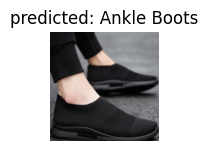

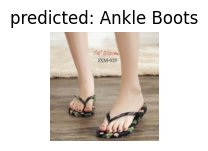

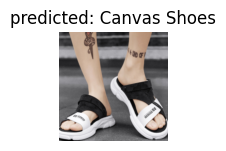

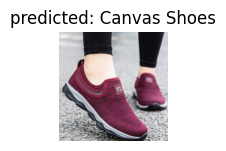

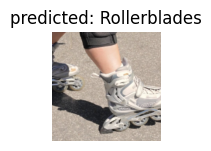

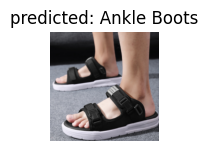

In [24]:
visualize_model(model)

In [25]:
test_loss, test_acc = test(dataloaders['test'], model, criterion)
print(f"Test: loss={test_loss:>8f}, acc={(100*test_acc):>0.1f}%")

Test: loss=0.205627, acc=91.2%


# Exercise: Create your own custom dataset

You need to create a new custom dataset for image classification whose datasets can be easily obtained from the Internet. Your dataset **MUST** have at least 4 classes. Then use this notebook to do transfer learning. You may want to adjust the code as appropriate:
* Change the model (e.g., EfficientNet, Inception, etc.) [[link](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights)]
* Change the training parameters (e.g., batch_size, learning rate, epoch, etc.)
* Change the number of layer to be frozen.
* and so on.

Please make sure that you have enough training (>=15), valid (>=5) and test (>=5) examples for each class.

In [26]:
# YOUR CODE HERE